In [1]:
raw_ncar_folder_path = '/home/idies/workspace/turb/data02_02/ncar-high-rate-fixed-dt/'
save_folder_path = '/home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code/zarr_reading/visualizations/'

var = 'e'

# timestep_range = range(5) # This will definitely crash the Kernel
timestep_nr = 3

In [2]:
# !pip install "xarray[complete]"

In [3]:
# needed for sciserver jobs
%cd /home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code/zarr_reading

/home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code/zarr_reading


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os

In [5]:
# for timestep_nr in timestep_range:
#     data = xr.open_dataset(raw_ncar_folder_path + "/jhd.00" + str(timestep_nr) + ".nc")


data_xr = xr.open_dataset(raw_ncar_folder_path + "/jhd.00" + str(timestep_nr) + ".nc")
# data = data['e']

In [6]:
steps = range(0, data_xr['e'].shape[2], 10)

# for i, z in enumerate(z_steps):
#     print(i,z)

### Runtimes

3min 45s +- 4min(!) to load Array `np.array(data[var])`

33.3s to plot using in-memory numpy array (from above)

14min 17s +- 6min for loading data using `data_xr[var][slice]` every time

Skipping the np.array loading takes wayyy too long (>1h for 7 runs atm)

<font color="red">Use np.array(data_xr['e'].isel(nnz=z_indices, nny=slice(None), nnx=slice(None)))!! Only 15sec!</font>

In [27]:
vars = list(data_xr.variables)
# vars.remove('u')
vars

['u', 'v', 'w', 't', 'p', 'e']

In [8]:
z_indices = list(range(0, 2000, 10))


for var in vars:
    for z in z_indices:
        # Fastest way to load Xarray data in memory
        slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(None), nnx=slice(None))) # Change this to slice along a different axis

        plt.figure(figsize=(20,20))
        plt.imshow(slice_data, cmap='gist_gray')#, vmin=-.5, vmax=.6)

    #     name = "[z,y,x=" + str(x) + "]" # x
    #     name = "[z,y=" +str(y) + ",x]" # y
        name = "[z=" +str(z) + ",y,x]" # z

        plt.title(name, fontsize=20)

        plt.savefig(f'visualizations/timestep_' + str(timestep_nr) + '/' + var + "/" + name + '.png')
        plt.close()

## Create movie

In [12]:
%cd visualizations

[Errno 2] No such file or directory: 'visualizations'
/home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code/zarr_reading/visualizations


<font color="orange">TODO fix wrong order of frames</font>

In [14]:
def extract_number_from_filename(filename):
    # Extract the numeric part of the filename
    # Assumes the filename format is 'y=NUMBER.png'
    return int(filename.split('=')[1].split(',')[0])

In [16]:
# Create GIF from PNG files
from PIL import Image

for var in vars:
    png_directory = os.path.join('timestep_' + str(timestep_nr), var)
    png_files = [file for file in os.listdir(png_directory) if file.endswith('.png')]
    png_files.sort(key=extract_number_from_filename)
    
#     print(png_files)
#     break

    frames = []

    for png_file in png_files:
        png_path = os.path.join(png_directory, png_file)
        image = Image.open(png_path)
        frames.append(image)

    output_gif_path = os.path.join(png_directory,'movie.gif')
    frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=200, loop=0)

### Figuring out why E is mostly black

Answer: Values at top are highest by orders of magnitude. Lower in the array they are all insignificant, hence the plots being mostly dark

In [8]:
e_arr = np.array(data_xr['e'][:,:,10])
e_arr

array([[2.1484870e-02, 2.5399648e-02, 3.1708486e-02, ..., 2.4137547e-02,
        2.7166588e-02, 2.3151362e-02],
       [4.3498043e-02, 2.9726245e-02, 3.3155590e-02, ..., 4.2431056e-02,
        6.2269416e-02, 6.5175407e-02],
       [3.5579521e-02, 3.3987552e-02, 3.6722168e-02, ..., 2.8427770e-02,
        3.0654615e-02, 3.3789847e-02],
       ...,
       [1.0003744e-09, 1.0019308e-09, 9.9997444e-10, ..., 1.0007558e-09,
        1.0024205e-09, 9.9993558e-10],
       [4.4538626e-09, 1.1322029e-09, 4.0484172e-09, ..., 3.5603815e-09,
        1.6835014e-09, 4.5581561e-09],
       [9.9999997e-10, 9.9999997e-10, 9.9999997e-10, ..., 9.9999997e-10,
        9.9999997e-10, 9.9999997e-10]], dtype=float32)

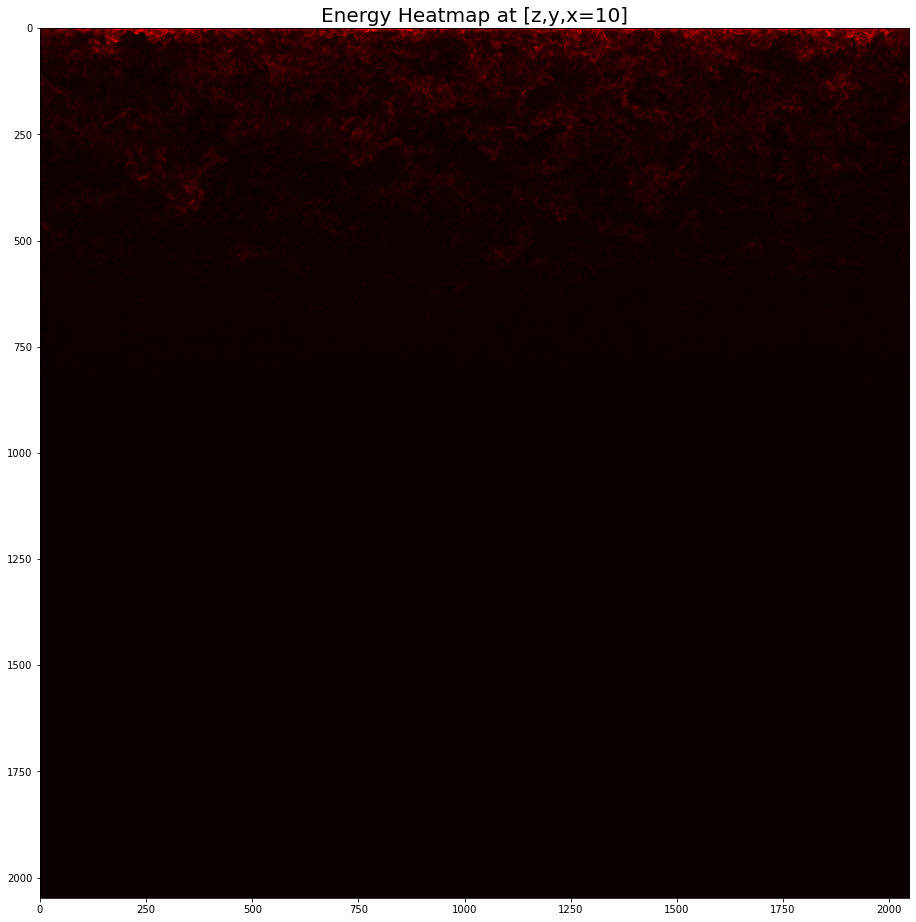

In [20]:
plt.figure(figsize=(16,16))

plt.title("Energy Heatmap at [z,y,x=10]", fontsize=20)

plt.imshow(e_arr,cmap='hot')

(array([4.158822e+06, 2.851600e+04, 5.368000e+03, 1.154000e+03,
        3.090000e+02, 9.000000e+01, 3.000000e+01, 5.000000e+00,
        5.000000e+00, 5.000000e+00]),
 array([-0.00068273,  0.025911  ,  0.05250473,  0.07909846,  0.10569219,
         0.13228591,  0.15887964,  0.18547337,  0.2120671 ,  0.23866083,
         0.26525456], dtype=float32),
 <BarContainer object of 10 artists>)

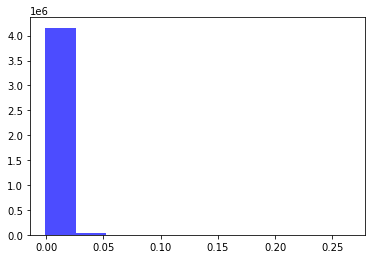

In [9]:
plt.hist(e_arr.flatten(), bins=10, color='blue', alpha=0.7)

In [13]:
t_arr = np.array(data_xr['t'][:,:,10])

In [14]:
t_arr

array([[-2.1424503, -2.1365209, -2.1266963, ..., -2.1497436, -2.1475194,
        -2.141476 ],
       [-2.0550828, -2.0339892, -2.041874 , ..., -2.036054 , -2.0523474,
        -2.0761018],
       [-2.0144298, -1.9998703, -1.9959269, ..., -2.0210168, -2.0106554,
        -2.0091054],
       ...,
       [ 2.9932077,  2.9932003,  2.993105 , ...,  2.9927418,  2.9924505,
         2.9928107],
       [ 2.9955866,  2.9954996,  2.9952042, ...,  2.9941282,  2.994607 ,
         2.9954097],
       [ 2.9970863,  2.9970624,  2.997076 , ...,  2.9967978,  2.99723  ,
         2.9973595]], dtype=float32)

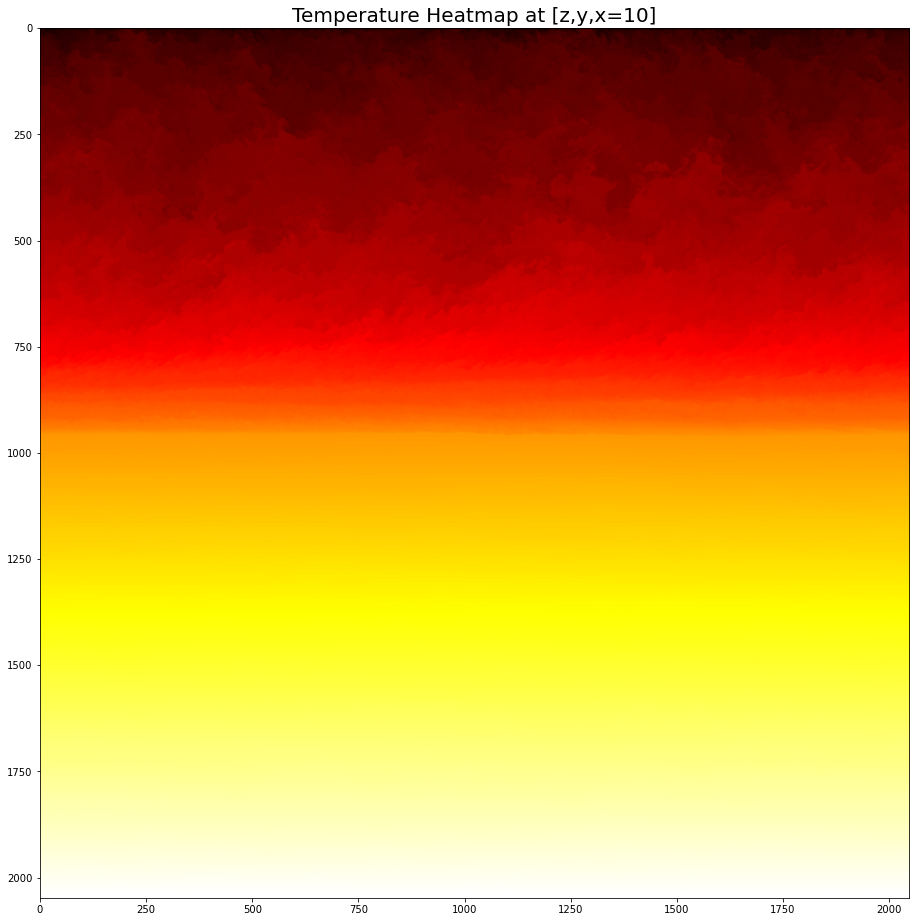

In [18]:
plt.figure(figsize=(16,16))

plt.title("Temperature Heatmap at [z,y,x=10]", fontsize=20)

plt.imshow(t_arr,cmap='hot')

(array([139340., 692604., 518457., 282027., 202093., 181995., 546535.,
        547120., 541616., 542517.]),
 array([-2.168687  , -1.6519741 , -1.1352609 , -0.6185479 , -0.10183482,
         0.41487825,  0.93159133,  1.4483044 ,  1.9650174 ,  2.4817305 ,
         2.9984436 ], dtype=float32),
 <BarContainer object of 10 artists>)

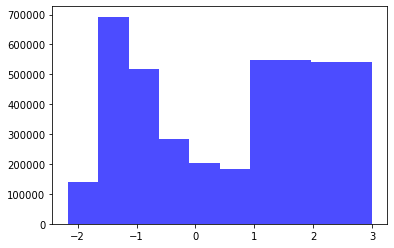

In [17]:
plt.hist(t_arr.flatten(), bins=10, color='blue', alpha=0.7)